# DQN

# Import the Libraries

In [1]:
import math
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.optimize import minimize
import scipy.stats

from PortfolioRebalancerEnv_signal_change import PortfolioRebalancerEnv

# Bellman

In [2]:

# Bellman equation
# V(s) = max_a sum_s' P(s,a,s') * (r(s,a,s') + gamma * V(s'))
# where P(s,a,s') is the probability of transitioning from state s to state s' with action a, and gamma is a discount factor that determines the importance of future rewards.
# V(s) = max_a E_s'[ r(s,a,s') + gamma * V(s') ]
class BellmanValue:
    # mu will change from period to period through mu_change_cov, which can be set through one-year forward PTVA study
    def __init__(self, num_asset, sigma_mat, mu_change_cov, transaction_cost, gamma):
        self.sigma_mat = sigma_mat
        self.mu_change_cov = mu_change_cov
        self.transaction_cost = transaction_cost
        self.gamma = gamma
        self.num_asset = num_asset
        x = np.arange(-7, 8)
        self.action_possible = np.array(np.meshgrid(*([x] * self.num_asset))).T.reshape(-1, self.num_asset)
        self.action_possible = self.action_possible[self.action_possible.sum(axis=1) == 0, :]
        x1 = np.arange(1, 101)
        x2 = np.arange(0, 401, 5)
        self.state_possible = np.array(np.meshgrid(*([x1] * self.num_asset + [x2] * self.num_asset))).T.reshape(-1, 2*self.num_asset)
        self.state_possible = self.state_possible[self.state_possible[:, 0:self.num_asset].sum(axis=1) == 100, :]
        self.state_col_wgt = range(0, self.num_asset)
        self.state_col_mu = range(self.num_asset, 2*self.num_asset)
        self.value_table = np.zeros(self.state_possible.shape[0])
        self.q_table = np.zeros((self.state_possible.shape[0], self.action_possible.shape[0]))

    def get_transition_prob(self, state_current, action):
        state_new_wgt = state_current[self.state_col_wgt] + action
        ret_drift = self.state_possible[:, self.state_col_wgt] / state_new_wgt
        ret_drift -= 1
        # this is only an approximation, it hasn't considered the weight renormalization
        prob_on_wgt = scipy.stats.multivariate_normal.logpdf(ret_drift, mean=state_current[self.state_col_mu]/10000, cov=self.sigma_mat)
        prob_on_wgt -= prob_on_wgt.max()

        # mu_change = self.state_possible[:, self.state_col_mu] - state_current[self.state_col_mu]
        x = np.arange(-400, 401, 5)
        mu_allow_neg = np.array(np.meshgrid(*([x] * self.num_asset))).T.reshape(-1, self.num_asset)
        prob_on_mu_change = scipy.stats.multivariate_normal.logpdf(mu_allow_neg, mean=state_current[self.state_col_mu], cov=self.mu_change_cov)
        df = pd.DataFrame(mu_allow_neg)
        df['prob'] = prob_on_mu_change
        mu_no_neg = np.maximum(mu_allow_neg, 0)
        df.iloc[:, :self.num_asset] = mu_no_neg
        df = df.groupby(list(range(self.num_asset))).sum().reset_index()
        prob_on_mu_change = df['prob'].values
        prob_on_mu_change -= prob_on_mu_change.max()
        prob_on_mu_change = [x for x in prob_on_mu_change for _ in range(self.state_possible.shape[0] // len(prob_on_mu_change)) ]

        probabilities = prob_on_wgt + np.array(prob_on_mu_change)
        probabilities -= probabilities.max()
        probabilities = np.exp(probabilities)
        probabilities /= np.sum(probabilities)
        return probabilities

    def calculate_value(self, state_wgt):
        action_value_current_state = []
        for action_id in range(self.action_possible.shape[0]):
            action = self.action_possible[action_id]
            new_state = state_wgt[self.state_col_wgt] + action
            if np.any(new_state <= 0):
                action_value = -np.inf
            else:
                transition_prob = self.get_transition_prob(state_wgt, action)
                reward = reward_sharpe_net_tc(state_wgt[self.state_col_wgt]/100, action/100, state_wgt[self.state_col_mu]/10000, self.sigma_mat, self.transaction_cost)
                next_state_value = self.value_table
                action_value = np.sum(transition_prob * (reward + self.gamma * next_state_value))
            action_value_current_state.append(action_value)
        return action_value_current_state

    def iterate_q_table_once(self):
        new_value_table = np.zeros(self.state_possible.shape[0])
        new_q_table = np.zeros((self.state_possible.shape[0], self.action_possible.shape[0]))
        for state_id in range(self.state_possible.shape[0]):
            state_wgt = self.state_possible[state_id]
            new_q_table[state_id, :] = self.calculate_value(state_wgt)
            new_value_table[state_id] = np.max(new_q_table[state_id, :])

        check_converged = np.sum(np.abs(self.value_table - new_value_table))
        self.value_table = new_value_table
        self.q_table = new_q_table

        return check_converged

# Create Replay Memory Class

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Create Q-Network

In [4]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [5]:

def net_sharpe(w1, mu, cov, w0, tc):
    # ROY NOTE: I changed w1 to w1.T in denominator
    return (w1.dot(mu) - cost_turnover(w0, w1, tc)) / np.sqrt(w1.dot(cov).dot(w1.T))

def reward_sharpe_net_tc(w0, d1, mu, cov, tc):
    w2 = w0 + d1

    # optimal net sharpe
    net_sharpe2 = (w2.dot(mu) - np.sum(np.abs(d1) * tc)) / np.sqrt(w2.dot(cov).dot(w2))

    return net_sharpe2

def obj_func(x, mu, cov):
    return -x.dot(mu) / np.sqrt(x.dot(cov).dot(x))
    # return 0.5 * (x.dot(cov).dot(x)) - x.dot(mu)


def find_optimal_wgt(mu, cov):

    n = len(mu)
    w_min = np.zeros(n)
    w_max = np.ones(n) * 2 / n
    x0 = np.ones(n) / n
    bounds = np.vstack([w_min, w_max]).T

    cstr = [{"type": "eq", "fun": lambda x: np.sum(x) - 1, "jac": lambda x: np.ones(n)}]
    opt = minimize(fun=obj_func, x0=x0, args=(mu, cov),
                   bounds=bounds,
                   constraints=cstr,
                   tol=1e-6,
                   options={"maxiter": 10000})

    if not opt.success:
        raise ValueError("optimization failed: {}".format(opt.message))

    return opt.x / opt.x.sum()


def cost_turnover(w0, w1, tc):
    return np.sum(np.abs(w1 - w0) * tc) / 2


def expected_cost_total(w0, w1, opt_w, mu, cov, tc):
    opt_net_sharpe = net_sharpe(opt_w, mu, cov, w0, tc)
    w1_net_sharpe = net_sharpe(w1, mu, cov, w0, tc)
    return opt_net_sharpe - w1_net_sharpe

In [6]:
df = pd.read_csv("./data/Data.csv", index_col=0)
df = df.apply(pd.to_numeric)
ret_df = df.pct_change()[1:]
print(ret_df.head())

         Close_A   Close_B
Date                      
3/1/13 -0.009699  0.011927
4/1/13  0.005072 -0.004811
7/1/13 -0.004350 -0.000445
8/1/13 -0.005592 -0.000840
9/1/13  0.005097  0.008598


In [7]:
# Initialize variables
num_asset = df.shape[1]
mu = ret_df.mean(axis=0).to_numpy()
cov = ret_df.cov()
sigma = np.diag(cov)
dates = pd.to_datetime(ret_df.index)

trans_cost = 10 / 1e4
pvta_sd = np.array([50, 50])
mu_change_cov = np.diag(pvta_sd ** 2) # TODO: Need explanation on this

In [8]:
n_manager = df.columns.size
optimal_weight = find_optimal_wgt(mu, cov)
x0 = np.ones(len(mu)) / len(mu)

In [9]:
env = PortfolioRebalancerEnv(
    mu=mu,
    mu_change_cov=mu_change_cov,
    cov=cov,
    w_optimal=optimal_weight,
    n_assets=n_manager,
    transaction_costs=trans_cost,
    mu_error=0
)

# set up matplotlib
# is_ipython = 'inline' in matplotlib.get_backend()
# if is_ipython:
#     from IPython import display
#
# plt.ion()

# if gpu is to be used
device = torch.device("cpu")

# Training

RL:
- BATCH_SIZE is the number of transitions sampled from the replay buffer
- GAMMA is the discount factor as mentioned in the previous section
- EPS_START is the starting value of epsilon
- EPS_END is the final value of epsilon
- EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
- TAU is the update rate of the target network
- LR is the learning rate of the AdamW optimizer

Finance:
- $\mu$ is historical mean returns for each asset
- $\Sigma$ is the historical covariance of returns

In [10]:
# RL:
BATCH_SIZE = 1000
GAMMA = 0.9
EPS_START = 0.99999
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

In [11]:
# Get number of actions from gym action space
n_actions = env.action_space.shape[0]
# Get the number of state observations
state, info = env.reset()
n_observations = env.input_size

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

In [12]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            # optimal_action_index = policy_net(state).max(1)[1].view(1, -1)
            optimal_action_index = policy_net(state).argmax()
            output = torch.tensor(env.action_space[optimal_action_index][np.newaxis, :], device=device, dtype=torch.float)
            return output
    else:
        temp_row_id = np.random.choice(env.action_space.shape[0], size=1)
        output = torch.tensor(env.action_space[temp_row_id], device=device, dtype=torch.float)
        return output

In [13]:
def convert_action_to_index(action_value):
    return np.where(np.isclose(env.action_space, action_value).all(axis=1))[0]

In [14]:
def optimize_model():
    global batch, state_batch, action_batch, reward_batch, int_act_batch, state_action_values, expected_state_action_values, next_state_values
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # print(batch.state)
    # print(batch.action)
    # print(batch.reward)
    # print("training")

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state
                                       if s is not None])
    state_batch = torch.stack(batch.state)
    action_batch = torch.stack(batch.action)
    reward_batch = torch.stack(batch.reward)

    int_act_batch=[]
    for i in action_batch:
        int_act_batch.append(np.where(np.isclose(env.action_space, i).any(axis=1))[0].item())

    int_act_batch = torch.tensor(int_act_batch, dtype=torch.int64)[:, np.newaxis]
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).squeeze().gather(1, int_act_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values[:, np.newaxis])
    print(f"Loss = {loss.item()}")

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

# Run Training

In [17]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

num_episodes = 200

In [18]:
# w_A_dict = dict()
weightA_array, weightA_dict = [], {}
action_array, action_dict = [], {}
reward_array, reward_dict = [], {}

policy_net_dict = {}
target_net_dict = {}

print("Iteration Start")

dqn_result = {}
dqn_loss = {}

for tc in [0, 0.0005, 0.001, 0.002]:
    print(f"Transaction Cost: {tc}")

    # Get number of actions from gym action space
    n_actions = env.action_space.shape[0]
    n_observations = env.input_size

    # Get the number of state observations
    state, info = env.reset()

    # reset env with new transaction cost
    # TODO: make all these methods of class DQN or PortfolioRebalancerEnv.py
    env.transaction_costs = tc

    policy_net = DQN(n_observations, n_actions).to(device)
    target_net = DQN(n_observations, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
    memory = ReplayMemory(10000)
    steps_done = 0

    for i_episode in range(num_episodes):
        # print("Epoch {}".format(i_episode))

        # Initialize the environment and get it's state
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device)
        # w_A_dict[i].append(state.squeeze().clone().detach())

        action = select_action(state)
        observation, reward, done = env.step(action.numpy().ravel())
        reward = torch.tensor(reward, device=device, dtype=torch.float32)

        if done:
            next_state = None
            # store variables for plotting
            weightA_array.append(state.squeeze().clone().detach())
            reward_array.append(reward.squeeze().clone().detach())
            action_array.append(action.squeeze().clone().detach())
        else:
            # get new state
            next_state = torch.tensor(observation, dtype=torch.float32, device=device)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        print(f"Epoch {i_episode}: Reward = {reward.squeeze().clone().detach()}")

    # store tc results
    dqn_result[tc] = env

    weightA_dict[tc] = weightA_array
    action_dict[tc] = action_array
    reward_dict[tc] = reward_array
    policy_net_dict[tc] = policy_net
    target_net_dict[tc] = target_net


Iteration Start
Transaction Cost: 0
Epoch 0: Reward = 0.916721522808075
Epoch 1: Reward = 0.030474994331598282
Epoch 2: Reward = 0.8758820295333862
Epoch 3: Reward = 1.9681074619293213
Epoch 4: Reward = 0.622127890586853
Epoch 5: Reward = 1.1440485715866089
Epoch 6: Reward = 0.32624438405036926
Epoch 7: Reward = 0.5461875200271606
Epoch 8: Reward = 0.042437098920345306
Epoch 9: Reward = 0.46549516916275024
Epoch 10: Reward = 0.2706001400947571
Epoch 11: Reward = 0.039115507155656815
Epoch 12: Reward = 0.8529115319252014
Epoch 13: Reward = 2.0165534019470215
Epoch 14: Reward = -0.12539079785346985
Epoch 15: Reward = -0.2657049298286438
Epoch 16: Reward = -0.17010577023029327
Epoch 17: Reward = 1.2161989212036133
Epoch 18: Reward = 0.6981245279312134
Epoch 19: Reward = 0.3611285090446472
Epoch 20: Reward = 1.6997212171554565
Epoch 21: Reward = 2.01189923286438
Epoch 22: Reward = 0.1304185390472412
Epoch 23: Reward = 1.3723176717758179
Epoch 24: Reward = 0.8986719250679016
Epoch 25: Rewar

In [19]:
x = env.state_possible[:, 0]
dqn_action_df = pd.DataFrame(index=x)
for tc, mo in dqn_result.items():
    # visualize q table
    action = []
    for j in range(mo.state_possible.shape[0]):
        if j == 0:
            print("Starting...")
        elif j == mo.state_possible.shape[0] - 1:
            print("Done!")
        qval = policy_net_dict[tc](torch.FloatTensor(mo.state_possible[j])).detach().numpy()
        action.append(mo.action_space[qval.argmax(), 0])

    action = np.array(action)
    dqn_action_df[f"TC: {tc * 1e4:.0f} bps"] = action

dqn_action_df

Starting...
Done!
Starting...
Done!
Starting...
Done!
Starting...
Done!


,TC: 0 bps,TC: 5 bps,TC: 10 bps,TC: 20 bps
1,-5,-2,-3,-4
2,-5,-2,-3,-4
3,-5,-2,-2,-4
4,-5,-2,-2,-4
5,-5,-2,-2,-4
...,...,...,...,...
95,-6,2,-1,-4
96,-6,2,-1,-4
97,-6,2,-1,-4
98,-6,2,-1,-4


## Run Bellman

In [20]:
# self = bell = BellmanValue(num_asset=2,
#                            sigma_mat=cov,
#                            mu_change_cov=mu_change_cov,
#                            transaction_cost=trans_cost,
#                            gamma=0.9)
# for dummy in range(200):
#     diff = bell.iterate_q_table_once()
#     print(diff)
#     if diff < 1e-4:
#         break
#     print("Iter {}: Value {}".format(dummy, diff))

In [21]:
# model_result = {}
# for tc in [0, 0.0005, 0.001, 0.002]:
#     self = bell = BellmanValue(mu, cov, tc, gamma=0.9)
#     bell.iterate()
#     model_result[tc] = bell

In [22]:
# x = self.state_possible[:, 0]
# action_df = pd.DataFrame(index=x)
# action_bm_df = pd.DataFrame(index=x)
# for tc, bell in model_result.items():
#     # visualize q table
#     action = np.array([bell.action_possible[i, 0] for i in bell.q_table.argmax(axis=1)])
#     action_df[f"TC: {tc * 1e4:.0f} bps"] = action
#     action_bm = []
#     for i in x:
#         a = x[np.argmax([net_sharpe(np.array([j, 1 - j]), mu, cov, np.array([i, 1 - i]), tc) for j in x])] - i
#         action_bm.append(a)
#     action_bm = np.array(action_bm)
#     action_bm_df[f"TC: {tc * 1e4:.0f} bps BM"] = action_bm

# Plot

In [23]:
plt.rcParams.update({"font.size": 18})

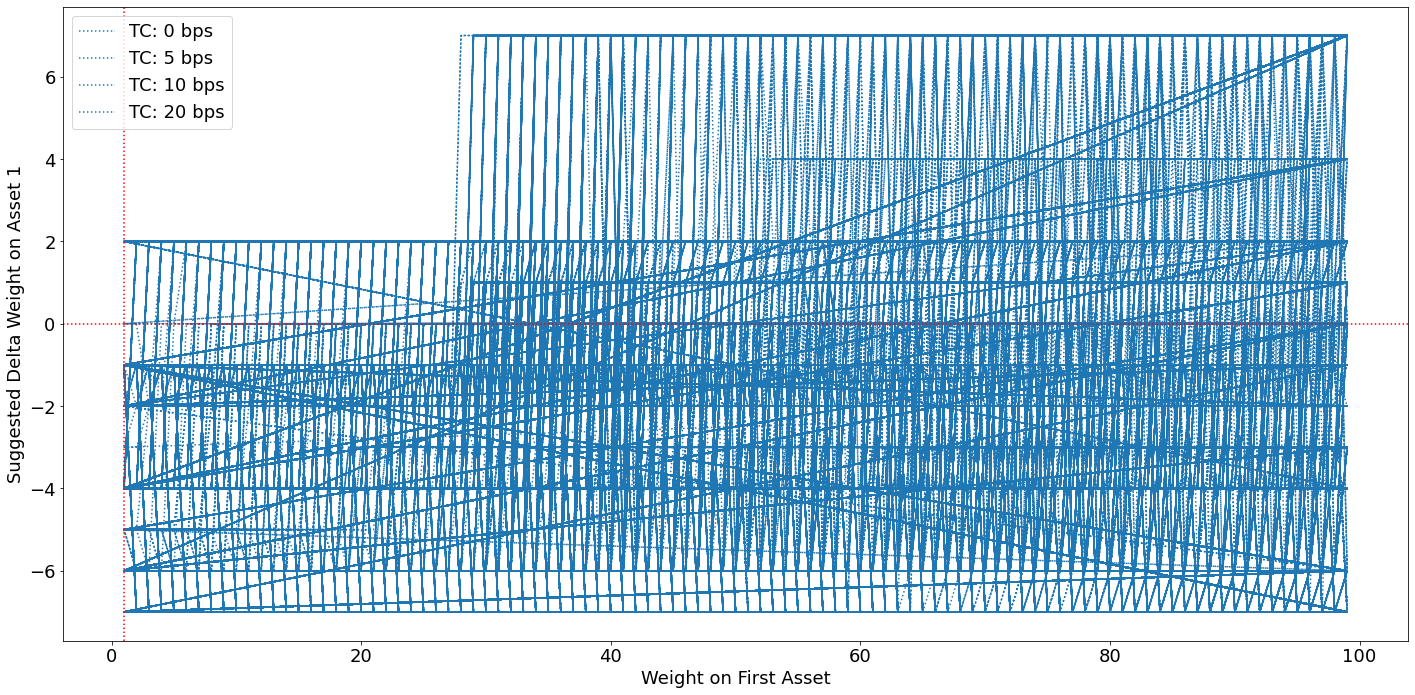

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
# ql_action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
# bell_action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], linestyle="dashed")
# dqn_action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], linestyle="dotted")
dqn_action_df.iloc[:, :].plot(ax=ax, color=['#1f77b4'], linestyle="dotted")
ax.set_xlabel("Weight on First Asset")
ax.set_ylabel("Suggested Delta Weight on Asset 1")
ax.axvline(optimal_weight[0], color="red", linestyle="dotted")
ax.axhline(0, color="red", linestyle="dotted")
ax.legend()
plt.tight_layout()
plt.show()
# mpl.savefig(os.path.expanduser(f"~/Desktop/bell_qlearn_dqn.png"))
# mpl.close()


In [27]:
dqn_action_df

,TC: 0 bps,TC: 5 bps,TC: 10 bps,TC: 20 bps
1,-5,-2,-3,-4
2,-5,-2,-3,-4
3,-5,-2,-2,-4
4,-5,-2,-2,-4
5,-5,-2,-2,-4
...,...,...,...,...
95,-6,2,-1,-4
96,-6,2,-1,-4
97,-6,2,-1,-4
98,-6,2,-1,-4


Currently it errors at epoch 999 and beyond 11K due to a concatenation/stacking issue.